# Import Libs

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.metrics import mean_squared_error


# Non Comp

## Part 1

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

# Load the dataset
train_df = pd.read_csv('kaggle_train.csv')
test_df = pd.read_csv('kaggle_test.csv')

# Drop 'Birth Weight' due to many missing or zero values
train_df.drop(columns=['Birth Weight'], inplace=True, errors='ignore')
test_df.drop(columns=['Birth Weight'], inplace=True, errors='ignore')

# Identify categorical and numerical features
categorical_features = [
    'Hospital Service Area', 'Hospital County', 'Operating Certificate Number',
    'Permanent Facility Id', 'Facility Name', 'Age Group', 'Zip Code - 3 digits',
    'Race', 'Ethnicity', 'Type of Admission', 'Patient Disposition',
    'CCSR Diagnosis Code', 'CCSR Procedure Code', 'APR DRG Code',
    'APR MDC Code', 'APR Severity of Illness Description',
    'APR Risk of Mortality', 'APR Medical Surgical Description',
    'Payment Typology 1', 'Payment Typology 2', 'Payment Typology 3',
    'Emergency Department Indicator'
]

numerical_features = ['Length of Stay']

# Convert categorical features to string type to avoid dtype mismatches
for col in categorical_features:
    train_df[col] = train_df[col].astype(str)
    test_df[col] = test_df[col].astype(str)

# Preprocessing pipeline
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value="missing")),  # Ensure categorical data remains string
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numerical_features),
    ('cat', categorical_transformer, categorical_features)
])

# Separate features and target
X = train_df.drop('Total Costs', axis=1)
y = train_df['Total Costs']

# Apply preprocessing before train-validation split
X_preprocessed = preprocessor.fit_transform(X)

# Split train into train-validation (90-10 split)
X_train, X_val, y_train, y_val = train_test_split(X_preprocessed, y, test_size=0.1, random_state=42)

# Print final shape of processed data
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)


X_train shape: (78835, 1775)
X_val shape: (8760, 1775)


## Part 2: EDA

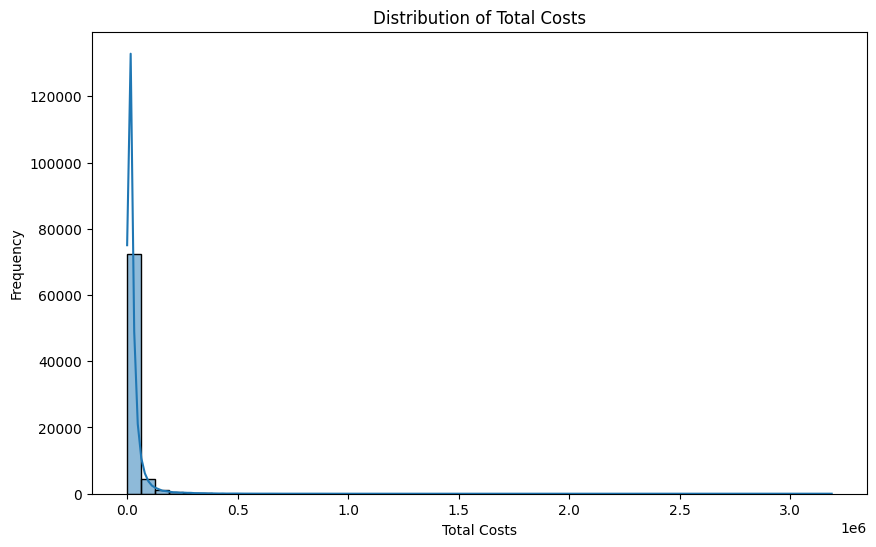

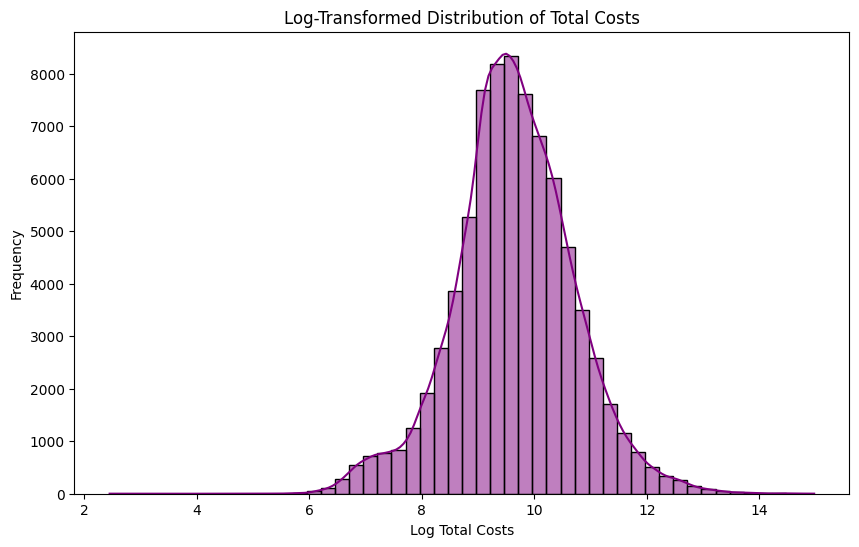

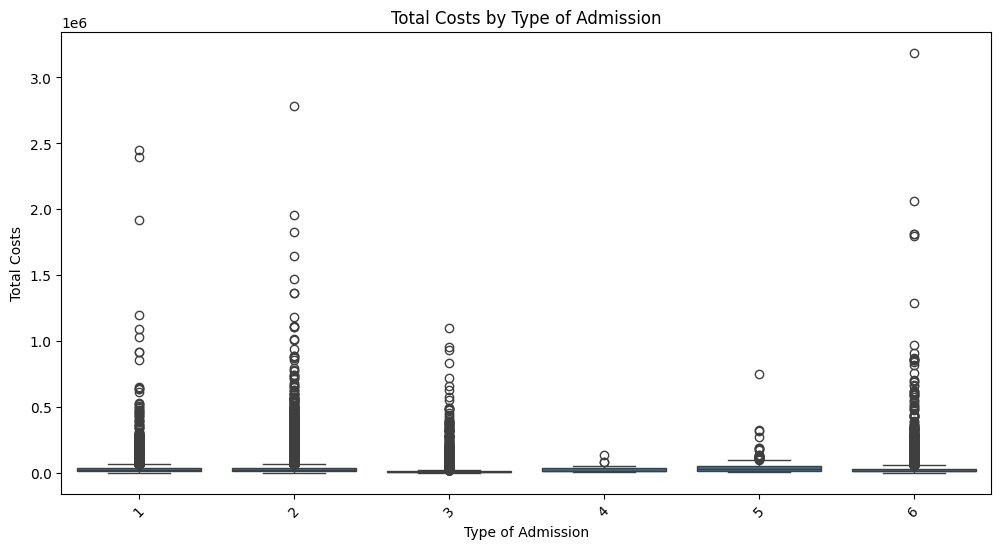

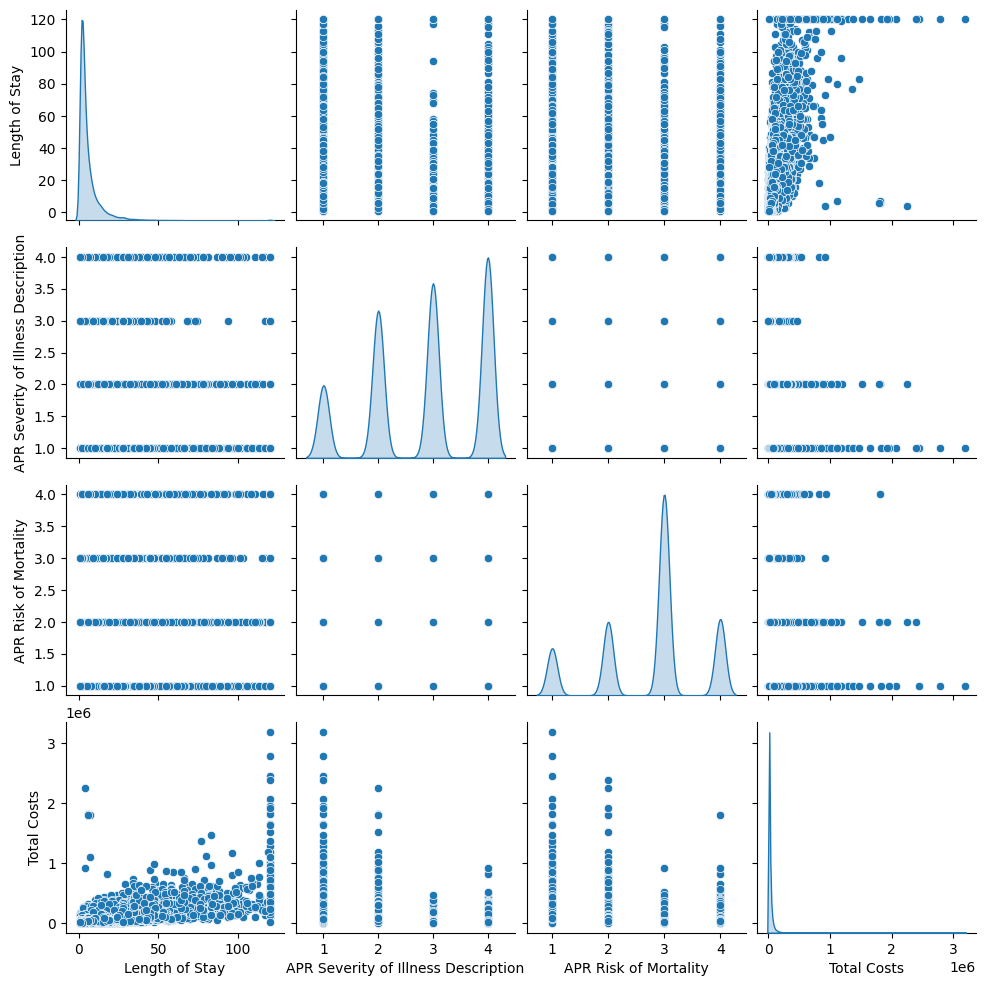

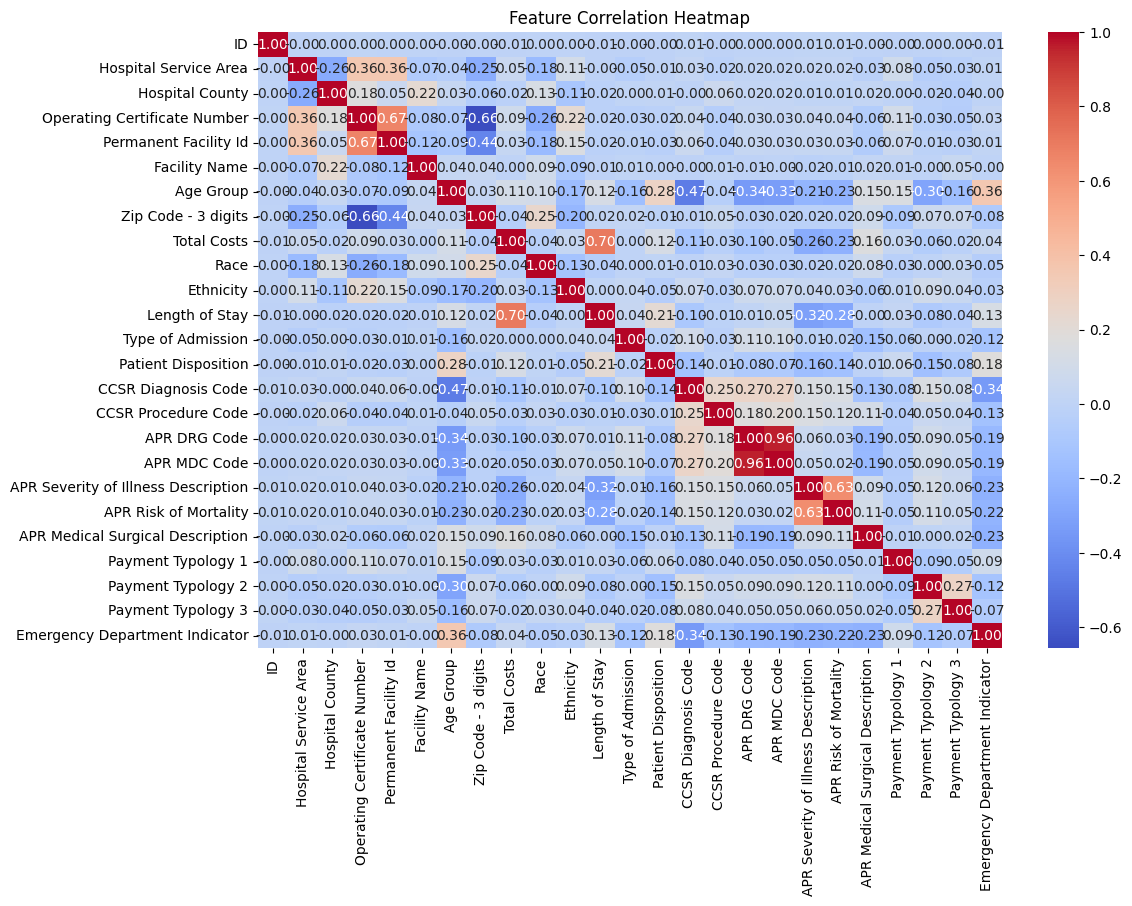

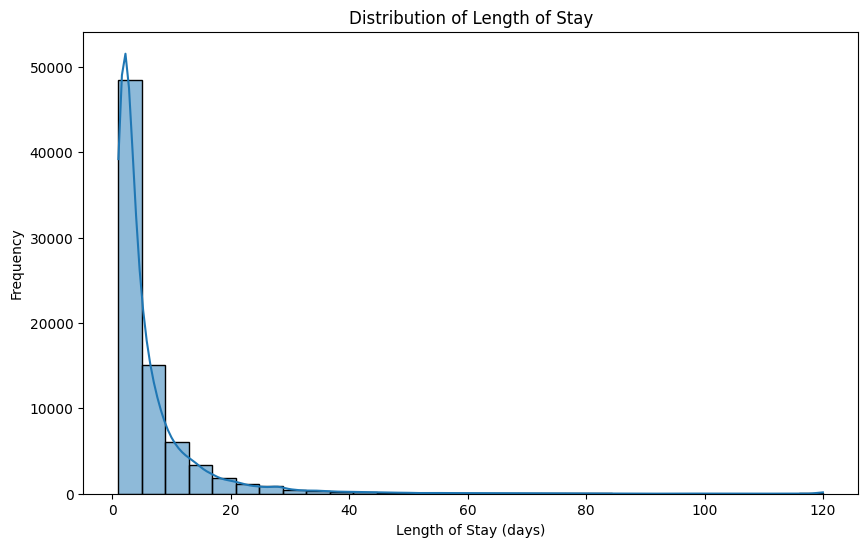

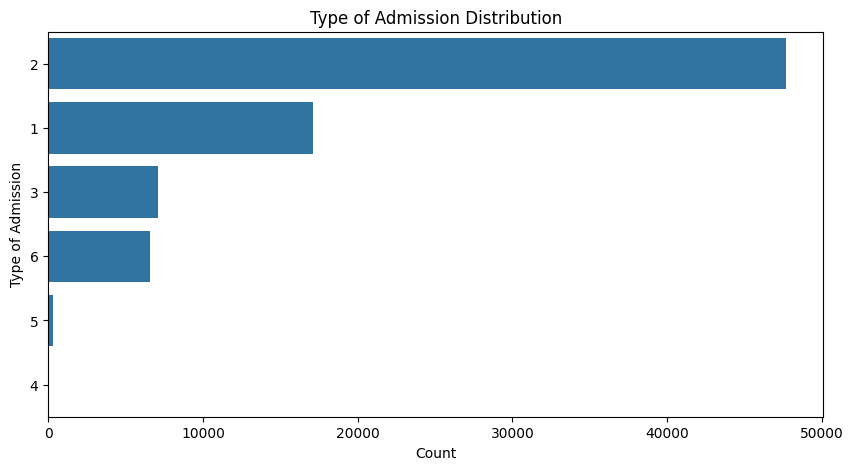

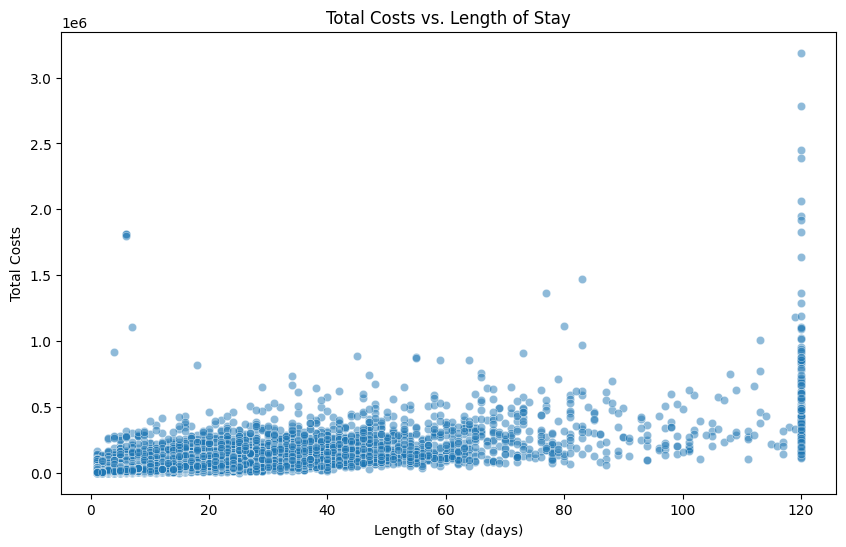

In [ ]:
# --------------------
# Exploratory Data Analysis (EDA)
# --------------------

# Distribution of Target Variable (Total Costs)
plt.figure(figsize=(10, 6))
sns.histplot(y_train, bins=50, kde=True)
plt.title('Distribution of Total Costs')
plt.xlabel('Total Costs')
plt.ylabel('Frequency')
plt.show()

# Log-Transformed Distribution of Total Costs (for skewness correction)
plt.figure(figsize=(10, 6))
sns.histplot(np.log1p(y_train), bins=50, kde=True, color='purple')
plt.title('Log-Transformed Distribution of Total Costs')
plt.xlabel('Log Total Costs')
plt.ylabel('Frequency')
plt.show()


# Box Plot of Total Costs by Type of Admission
plt.figure(figsize=(12, 6))
sns.boxplot(x=X_train['Type of Admission'], y=y_train)
plt.xticks(rotation=45)
plt.title('Total Costs by Type of Admission')
plt.show()

# Pairplot for Key Features
selected_features = ['Length of Stay', 'APR Severity of Illness Description', 'APR Risk of Mortality']
pairplot_df = train_df[selected_features + ['Total Costs']].copy()
sns.pairplot(pairplot_df, diag_kind='kde')
plt.show()

# Correlation Heatmap of Numeric Features
plt.figure(figsize=(12, 8))
correlation_matrix = train_df.select_dtypes(include=[np.number]).corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Heatmap')
plt.show()

# Distribution of Length of Stay
plt.figure(figsize=(10, 6))
sns.histplot(X_train['Length of Stay'], bins=30, kde=True)
plt.title('Distribution of Length of Stay')
plt.xlabel('Length of Stay (days)')
plt.ylabel('Frequency')
plt.show()

# Count Plot for Categorical Features (Example: Type of Admission)
plt.figure(figsize=(10, 5))
sns.countplot(y=X_train['Type of Admission'], order=X_train['Type of Admission'].value_counts().index)
plt.title('Type of Admission Distribution')
plt.xlabel('Count')
plt.show()

# Relationship Between Length of Stay and Total Costs
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_train['Length of Stay'], y=y_train, alpha=0.5)
plt.title('Total Costs vs. Length of Stay')
plt.xlabel('Length of Stay (days)')
plt.ylabel('Total Costs')
plt.show()


## Part 3: LR

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error

# --------------------
# Linear Regression (Closed-Form Solution)
# --------------------
def closed_form_solution(X, y):
    X_b = np.c_[np.ones((X.shape[0], 1)), X]  # Add bias term (intercept)
    theta = np.linalg.pinv(X_b.T @ X_b) @ X_b.T @ y  # Compute closed-form solution
    return theta

# Convert sparse matrix to dense
X_train_dense = X_train.toarray() if hasattr(X_train, "toarray") else X_train
X_val_dense = X_val.toarray() if hasattr(X_val, "toarray") else X_val

# Convert y_train to NumPy and reshape
y_train_array = y_train.to_numpy().reshape(-1, 1)

# Compute closed-form solution
theta = closed_form_solution(X_train_dense, y_train_array)

# Add bias term to validation data
X_val_b = np.c_[np.ones((X_val_dense.shape[0], 1)), X_val_dense]

# Make predictions
y_pred_closed_form = X_val_b @ theta

# Compute Mean Squared Error (MSE)
mse_closed_form = mean_squared_error(y_val, y_pred_closed_form)
print(f'Closed-form Solution MSE: {mse_closed_form:.4f}')


Closed-form Solution MSE: 1783698784.0446


In [ ]:
# --------------------
# Gradient Descent Implementations
# --------------------

def vanilla_gradient_descent(X, y, learning_rate=0.01, epochs=100):
    """Vanilla Gradient Descent (Batch GD)"""
    m, n = X.shape
    X_b = np.c_[np.ones((m, 1)), X]  # Add bias term
    theta = np.random.randn(n + 1, 1)

    for epoch in tqdm.tqdm(range(epochs)):
        gradients = (2 / m) * X_b.T @ (X_b @ theta - y)
        theta -= learning_rate * gradients

    return theta

def stochastic_gradient_descent(X, y, learning_rate=0.01, epochs=100):
    """Stochastic Gradient Descent (SGD)"""
    m, n = X.shape
    X_b = np.c_[np.ones((m, 1)), X]
    theta = np.random.randn(n + 1, 1)

    for epoch in tqdm.tqdm(range(epochs)):
        for i in range(m):
            random_idx = np.random.randint(m)
            xi = X_b[random_idx:random_idx+1]
            yi = y[random_idx:random_idx+1]
            gradients = 2 * xi.T @ (xi @ theta - yi)
            theta -= learning_rate * gradients

    return theta

def mini_batch_gradient_descent(X, y, learning_rate=0.01, epochs=100, batch_size=32):
    """Mini-Batch Gradient Descent"""
    m, n = X.shape
    X_b = np.c_[np.ones((m, 1)), X]
    theta = np.random.randn(n + 1, 1)

    for epoch in tqdm.tqdm(range(epochs)):
        shuffled_indices = np.random.permutation(m)
        X_b_shuffled = X_b[shuffled_indices]
        y_shuffled = y[shuffled_indices]

        for i in range(0, m, batch_size):
            xi = X_b_shuffled[i:i + batch_size]
            yi = y_shuffled[i:i + batch_size]
            gradients = (2 / max(1, len(xi))) * xi.T @ (xi @ theta - yi)
            theta -= learning_rate * gradients

    return theta

# Compute predictions and MSE for validation set
def compute_mse(theta, X_val, y_val):
    X_val_b = np.c_[np.ones((X_val.shape[0], 1)), X_val]
    y_pred = X_val_b @ theta
    return mean_squared_error(y_val, y_pred)



# Convert sparse matrix to dense
X_train_dense = X_train.toarray() if hasattr(X_train, "toarray") else X_train
X_val_dense = X_val.toarray() if hasattr(X_val, "toarray") else X_val

# Convert y_train to NumPy and reshape
y_train_array = y_train.to_numpy().reshape(-1, 1)
y_val_array = y_val.to_numpy().reshape(-1, 1)


# Compute results for different gradient descent variations
theta_vgd = vanilla_gradient_descent(X_train_dense, y_train_array)  # Vanilla GD
mse_vgd = compute_mse(theta_vgd, X_val_dense, y_val_array)
print(f'Vanilla (Batch) Gradient Descent MSE: {mse_vgd:.4f}')


theta_sgd = stochastic_gradient_descent(X_train_dense, y_train_array)  # Stochastic GD
mse_sgd = compute_mse(theta_sgd, X_val_dense, y_val_array)
print(f'Stochastic Gradient Descent MSE: {mse_sgd:.4f}')


theta_mbgd = mini_batch_gradient_descent(X_train_dense, y_train_array, batch_size=32)  # Mini-Batch GD
mse_mbgd = compute_mse(theta_mbgd, X_val_dense, y_val_array)
print(f'Mini-Batch Gradient Descent MSE: {mse_mbgd:.4f}')


100%|██████████| 100/100 [01:27<00:00,  1.14it/s]


Vanilla (Batch) Gradient Descent MSE: 2207207184.1066


100%|██████████| 100/100 [04:00<00:00,  2.41s/it]


Stochastic Gradient Descent MSE: 2106378475.6841


100%|██████████| 100/100 [01:17<00:00,  1.28it/s]

Mini-Batch Gradient Descent MSE: 1692548826.3893


## Part 4: LR and Ridge

In [ ]:
# --------------------
# Lasso and Ridge Regression
# --------------------
ridge = Ridge(alpha=10.0)
ridge.fit(X_train_dense, y_train)
y_pred_ridge = ridge.predict(X_val_dense)
mse_ridge = mean_squared_error(y_val_array, y_pred_ridge)

lasso = Lasso(alpha=10.0)
lasso.fit(X_train_dense, y_train_array)
y_pred_lasso = lasso.predict(X_val_dense)
mse_lasso = mean_squared_error(y_val_array, y_pred_lasso)

print(f'Ridge Regression MSE: {mse_ridge:.4f}')
print(f'Lasso Regression MSE: {mse_lasso:.4f}')

Ridge Regression MSE: 1692297843.3189
Lasso Regression MSE: 1710571858.2421


## Compare to existing

In [ ]:

# --------------------
# Compare with Scikit-learn's Linear Regression
# --------------------
sklearn_lr = LinearRegression()
sklearn_lr.fit(X_train_dense, y_train_array)
y_pred_sklearn = sklearn_lr.predict(X_val_dense)
mse_sklearn = mean_squared_error(y_val_array, y_pred_sklearn)
print(f'Scikit-learn Linear Regression MSE: {mse_sklearn:.4f}')

Scikit-learn Linear Regression MSE: 1783694082.1538
